# model estimation and fitting

### 1. necessary imports

In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from fredapi import Fred
import os

2. load data

In [2]:
y = pd.read_csv("data/gdp_yoy.csv", index_col=0, parse_dates=True).squeeze("columns").asfreq("QS")
y

1948-01-01    2.611513
1948-04-01    4.584426
1948-07-01    5.401228
1948-10-01    3.893672
1949-01-01    0.943214
                ...   
2024-01-01    2.901832
2024-04-01    3.036849
2024-07-01    2.718769
2024-10-01    2.533684
2025-01-01    2.049750
Freq: QS-JAN, Name: GDP_YoY, Length: 309, dtype: float64

### 3. Modelling
- model simple MS-AR(1):
    - 2 regimes
    - mean ($\mu$) & variance ($\sigma^2$) switch

In [3]:
mod = sm.tsa.MarkovAutoregression(
    y,
    k_regimes=2,
    order=1,
    switching_ar=False,
    switching_variance=True,
    trend="c",
)

res = mod.fit(maxiter=1000, disp=False)

print(res.summary())

                         Markov Switching Model Results                         
Dep. Variable:                  GDP_YoY   No. Observations:                  308
Model:             MarkovAutoregression   Log Likelihood                -500.899
Date:                  Sat, 17 May 2025   AIC                           1015.799
Time:                          18:32:09   BIC                           1041.909
Sample:                      01-01-1948   HQIC                          1026.239
                           - 01-01-2025                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9048      0.320      9.073      0.000       2.277       3.532
sigma2         0.4470      0.065    

### 4. get NBER recession calls and overlay ontop of smoothed marginal probability of regime 2
- this is a sanity check to show how well the calculated probability of recession (regime 2) fits the actual recession calls

In [6]:
fred = Fred(api_key=os.getenv("FRED_API_KEY"))
rec = fred.get_series("USRECQ").asfreq("QS")
rec

1854-10-01    1.0
1855-01-01    0.0
1855-04-01    0.0
1855-07-01    0.0
1855-10-01    0.0
             ... 
2024-01-01    0.0
2024-04-01    0.0
2024-07-01    0.0
2024-10-01    0.0
2025-01-01    0.0
Freq: QS-JAN, Length: 682, dtype: float64

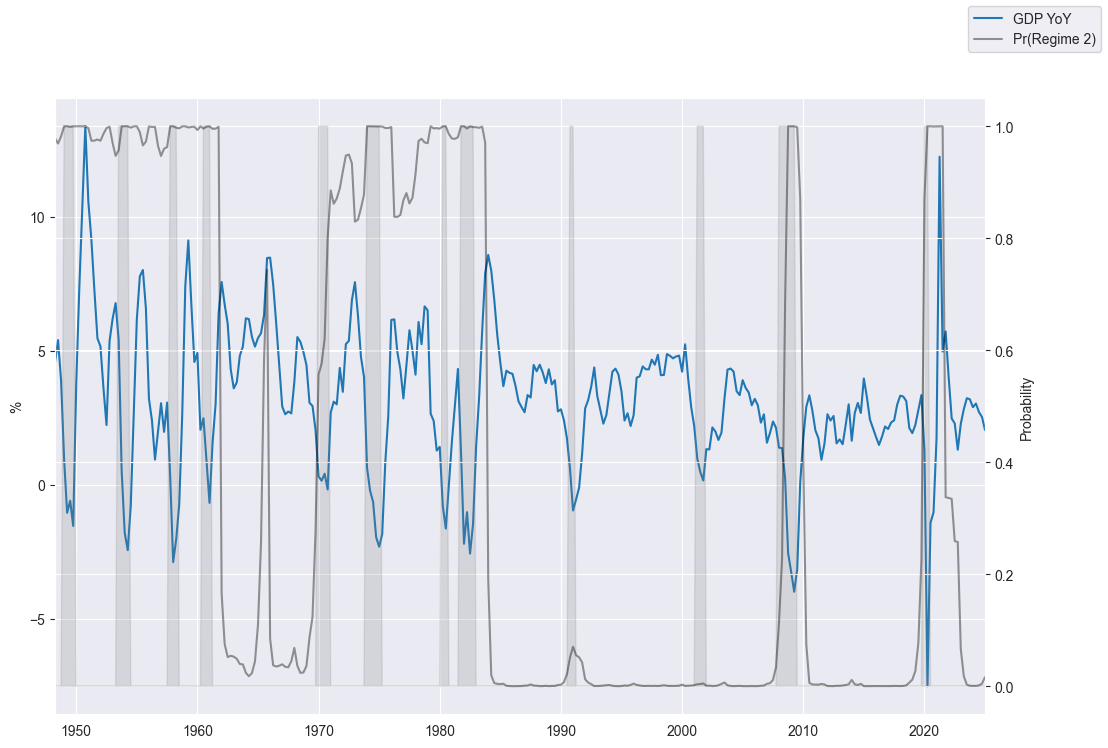

In [9]:
probs = res.smoothed_marginal_probabilities[1]

fig, ax = plt.subplots(figsize=(12, 8))
y.plot(ax=ax, label="GDP YoY")
ax.set_ylabel("%")

ax2 = ax.twinx()
probs.plot(ax=ax2, color="k", alpha=0.4, label="Pr(Regime 2)")
ax2.set_ylabel("Probability")
ax2.fill_between(rec.index, 0, rec, color="grey", alpha=0.2)
fig.legend(loc="upper right")
plt.show()